In this notebook, we present an algorithm that maps 2D data to 1D and show that 1D CNNs comparable with 2D CNNs. In particular, we read image pixels with Hilbert and modified Sierpinski space-filling curves, and then apply one-dimensional convolutional neural networks. 

We know that space-filling curves preserve a maximum of spatial locality information between elements. We believe that using space-filling curve mapping as a preprocessing tool, preserves enough information of neighbouring pixels to be used by 1D CNNs. We evaluated the classification performance of 1D CNNs on Cifar-10 image dataset. This mapping technique reduces CNN training cost while performs comparably to 2D CNNs.  


In [1]:
import numpy as np
import math
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops

import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.utils import np_utils
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.callbacks import LearningRateScheduler


from space_filling_curves import rix, hilbert_curve, scan_image_with_hilbert, modified_sierpinski_curve, scan_image_with_sierpinski

Using TensorFlow backend.


The CIFAR-10 dataset consists of 60000 32x32x3 color images in 10 equal classes. There are 50000 training images and 10000 test images. Each class of images corresponds to a physical object such as airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck. 

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)
It is a bird!


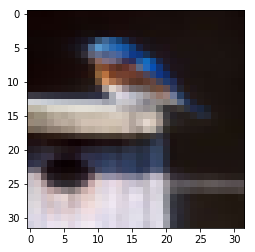

In [35]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
num_classes = 10
cifar10_classes = {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer', 
                      5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)



def draw_cifar_image(i):
    img = x_train[i]
    label = y_train[i]    
    plt.imshow(img)

    
print("It is a " + str(cifar10_classes[int(y_train[13])]) + "!")
draw_cifar_image(13)    


We can read the image pixels with Hilbert space-filling curve or modified Sierpinski space-filling curve. The main difference between these two curves is that modified Sierpinski curve is more symmetrical and closed.

Here, for example, we read the red matrix of the 4x4x3 image with Hilbert curve in the following order: 35, 19, 22, 13, 4, 0, 8, 3, 7, 1, 3, 10, 53, 16, 25, 6. We read the red matrix of the 4x4x3 image with modified Sierpinski curve in the following order: 35, 19, 22, 25, 6, 53, 16, 10, 3, 1, 7, 8, 0, 4, 3, 13. The code in Python 3 (see space_filling_curves.py) shows how to build the modified Nth order Sierpinski curve and Nth order Hilbert curve.


2nd-order Hilbert curve | 2nd-order modified Sierpiński curve
:-------------------------:|:-------------------------:
<img src="images/hilbertRGB.png" style="width:400px;height:300px"/>  |  <img src="images/readwithcurve.png" style="width:400px;height:300px"/>



Although it is possible to use lower order of the curves to read images, it is not recommended for small images. Here we preserve every pixel in image. 

In [36]:
num_px = x_train.shape[1]
N = math.log10(num_px) / math.log10(2)
N = int(N) # to cover all pixels
print("The order of the curve is " + str(N)) 
#x,y = modified_sierpinski_curve(N)
x,y = hilbert_curve(N)

# normalize data
X_train_orig = x_train/255.
X_test_orig = x_test/255.
mtrain = X_train_orig.shape[0]
mtest = X_test_orig.shape[0]

# convert to one-hot presentation
Y_train = keras.utils.to_categorical(y_train, num_classes)
Y_test = keras.utils.to_categorical(y_test, num_classes)

# print shapes
print(X_train_orig.shape)
print(X_test_orig.shape)
print(Y_train.shape)
print(Y_test.shape)

The order of the curve is 5
(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 10)
(10000, 10)


We create arrays of zeros and read pixels with Hilbert curve for Red, Green, and Blue channels. The data therefore transformed from (number of examples, number of pixels, number of pixels, 3) to (number of examples, $2^{2N}$, 3), where $N$ is the order of the curve.

In [37]:
train_data = np.zeros([X_train_orig.shape[0], 2**(2*N), X_train_orig.shape[3]])
test_data = np.zeros([X_test_orig.shape[0], 2**(2*N), X_test_orig.shape[3]])

train_data[:, :, 0] = scan_image_with_hilbert(N, mtrain, X_train_orig[:, :, :, 0], x, y)        
test_data[:, :, 0] = scan_image_with_hilbert(N, mtest, X_test_orig[:, :, :, 0], x, y) 

train_data[:, :, 1] = scan_image_with_hilbert(N, mtrain, X_train_orig[:, :, :, 1], x, y)        
test_data[:, :, 1] = scan_image_with_hilbert(N, mtest, X_test_orig[:, :, :, 1], x, y) 

train_data[:, :, 2] = scan_image_with_hilbert(N, mtrain, X_train_orig[:, :, :, 2], x, y)        
test_data[:, :, 2] = scan_image_with_hilbert(N, mtest, X_test_orig[:, :, :, 2], x, y) 

# new shapes
print(train_data.shape)
print(test_data.shape)

(50000, 1024, 3)
(10000, 1024, 3)


We define the model as a Sequential model in Keras. We define the model as having two blocks of two 1D CNN layers followed by  a pooling layer, then a dropout layer for regularization. After that, the learned features are flattened to a vector and pass through a fully connected layer. Then the output layer used to make predictions. We use batch normalization and ELU activation function elsewhere. Adam optimizer with default learning rate of 0.001 was used. We trained this model for 10 epochs using batches of 32 examples and achieved 88% train accuracy and 70.06% test accuracy. It took 1550 seconds to run. 


More details about the model hyperparameters are below:

In the first block we use
- 1D convolutional layers with 32 filters (feature detectors), each of length 4 (kernel size or sliding window). In this initial layer, 32 sliding windows of size 4 will run through the data to learn basic features.
- The exponential linear unit (ELU) activation function has a nonzero gradient for $z < 0$. It was used to avoid the dying units issue (some neurons die and output 0) when using RELU.
- To zero-center and normalize the inputs, we use the batch normalization techique that evaluates mean and standard deviation  of the inputs over the current mini-batch. This technique makes the networks much less sensitive to the weight initialization.
- MaxPooling of size 2 and stride 1 was applied by taking the max value of every 2 features.
- Dropout layer with rate 0.25 was used to ensure that at every trainig step, every input neuron has the probability 0.25 of being temporarily dropped (ignored).

The second block is similar to the first one, except more filters were used and AveragePooling was used instead of MaxPooling. After that we 'flatten' and turn the output into a vector. The first fully connected layer defined as Dense(128) takes the input from the features analysis and applies weights to predict the correct label. The last output layer defined by Dense(num_classes) uses a softmax activation function to give probabilities for the num_classes=10 output classes.


We train our model for 10 epochs, meaning that we completely pass through the training dataset 10 times. After evey 32 training examples (batch_size=32) the model's internal parameters were updated.

In [38]:
import time
import random

random.seed(2802)
start_time = time.time()

# Create the model
model = Sequential()

#сreating 32 different filters, each of them with length 4.
model.add(Conv1D(32, 4, input_shape=train_data.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv1D(32, 4))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv1D(64, 4))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv1D(64, 4))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(AveragePooling1D(pool_size=2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

epochs = 10
batch_size = 32

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

model.fit(train_data, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(test_data, Y_test))
score = model.evaluate(test_data, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print("--- %s seconds ---" % (time.time() - start_time))


Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 154s 3ms/step - loss: 1.4306 - acc: 0.5003 - val_loss: 1.1097 - val_acc: 0.6051
Epoch 2/10
50000/50000 [==============================] - 153s 3ms/step - loss: 1.0699 - acc: 0.6208 - val_loss: 1.0559 - val_acc: 0.6265
Epoch 3/10
50000/50000 [==============================] - 152s 3ms/step - loss: 0.9221 - acc: 0.6740 - val_loss: 0.8827 - val_acc: 0.6910
Epoch 4/10
50000/50000 [==============================] - 153s 3ms/step - loss: 0.7974 - acc: 0.7192 - val_loss: 0.8785 - val_acc: 0.6874
Epoch 5/10
50000/50000 [==============================] - 155s 3ms/step - loss: 0.6768 - acc: 0.7604 - val_loss: 0.8992 - val_acc: 0.6869
Epoch 6/10
50000/50000 [==============================] - 151s 3ms/step - loss: 0.5796 - acc: 0.7943 - val_loss: 0.9118 - val_acc: 0.6985
Epoch 7/10
50000/50000 [==============================] - 160s 3ms/step - loss: 0.4925 - acc: 0.8261 - val_loss: 0.9535 - 

Previously we read pixels with Hilbert curve. Here we read pixels with modified Sierpinski curve and use the same model as above to train 1D CNNs. After 10 epochs the model achieved 87.52% train accuracy and 70.37% test accuracy in 1546 seconds. 

In [40]:
# read with modified Sierpinski curve

x,y = modified_sierpinski_curve(N)

train_data = np.zeros([X_train_orig.shape[0], 2**(2*N), X_train_orig.shape[3]])
test_data = np.zeros([X_test_orig.shape[0], 2**(2*N), X_test_orig.shape[3]])

train_data[:, :, 0] = scan_image_with_hilbert(N, mtrain, X_train_orig[:, :, :, 0], x, y)        
test_data[:, :, 0] = scan_image_with_hilbert(N, mtest, X_test_orig[:, :, :, 0], x, y) 

train_data[:, :, 1] = scan_image_with_hilbert(N, mtrain, X_train_orig[:, :, :, 1], x, y)        
test_data[:, :, 1] = scan_image_with_hilbert(N, mtest, X_test_orig[:, :, :, 1], x, y) 

train_data[:, :, 2] = scan_image_with_hilbert(N, mtrain, X_train_orig[:, :, :, 2], x, y)        
test_data[:, :, 2] = scan_image_with_hilbert(N, mtest, X_test_orig[:, :, :, 2], x, y) 



# train 1D CNNs
random.seed(2802)
start_time = time.time()

# Create the model
model = Sequential()

model.add(Conv1D(32, 4, input_shape=train_data.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv1D(32, 4))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv1D(64, 4))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv1D(64, 4))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(AveragePooling1D(pool_size=2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

epochs = 10
batch_size = 32

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

model.fit(train_data, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(test_data, Y_test))
score = model.evaluate(test_data, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print("--- %s seconds ---" % (time.time() - start_time))

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 156s 3ms/step - loss: 1.4329 - acc: 0.4987 - val_loss: 1.1518 - val_acc: 0.5845
Epoch 2/10
50000/50000 [==============================] - 154s 3ms/step - loss: 1.0670 - acc: 0.6209 - val_loss: 1.0010 - val_acc: 0.6444
Epoch 3/10
50000/50000 [==============================] - 154s 3ms/step - loss: 0.9283 - acc: 0.6723 - val_loss: 0.8897 - val_acc: 0.6869
Epoch 4/10
50000/50000 [==============================] - 153s 3ms/step - loss: 0.7928 - acc: 0.7203 - val_loss: 0.8774 - val_acc: 0.6927
Epoch 5/10
50000/50000 [==============================] - 157s 3ms/step - loss: 0.6923 - acc: 0.7549 - val_loss: 0.9136 - val_acc: 0.6952
Epoch 6/10
50000/50000 [==============================] - 156s 3ms/step - loss: 0.5892 - acc: 0.7941 - val_loss: 0.9107 - val_acc: 0.6870
Epoch 7/10
50000/50000 [==============================] - 154s 3ms/step - loss: 0.5135 - acc: 0.8183 - val_loss: 0.8971 - 

Here we apply 2D CNNs to the original data. We use similar architecture as for 1D CNNs. The model achieves 77.44% train accuracy and 77.14% test accuracy in 1353 seconds. 

In [8]:
import time
import random

random.seed(2802)
start_time = time.time()

# Create the model
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same',
                 input_shape=X_train_orig.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

epochs = 10
batch_size = 32

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

model.fit(X_train_orig, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test_orig, Y_test))
score = model.evaluate(X_test_orig, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print("--- %s seconds ---" % (time.time() - start_time))

#loss: 0.6401 - acc: 0.7744 - val_loss: 0.6594 - val_acc: 0.7714 1353.63 seconds ---

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 133s 3ms/step - loss: 1.5394 - acc: 0.4585 - val_loss: 1.7792 - val_acc: 0.3948
Epoch 2/10
50000/50000 [==============================] - 132s 3ms/step - loss: 1.0983 - acc: 0.6124 - val_loss: 0.9536 - val_acc: 0.6668
Epoch 3/10
50000/50000 [==============================] - 134s 3ms/step - loss: 0.9421 - acc: 0.6671 - val_loss: 0.8806 - val_acc: 0.6908
Epoch 4/10
50000/50000 [==============================] - 135s 3ms/step - loss: 0.8605 - acc: 0.6993 - val_loss: 0.7699 - val_acc: 0.7276
Epoch 5/10
50000/50000 [==============================] - 136s 3ms/step - loss: 0.7957 - acc: 0.7208 - val_loss: 0.8048 - val_acc: 0.7161
Epoch 6/10
50000/50000 [==============================] - 135s 3ms/step - loss: 0.7545 - acc: 0.7366 - val_loss: 0.8438 - val_acc: 0.7029
Epoch 7/10
50000/50000 [==============================] - 135s 3ms/step - loss: 0.7180 - acc: 0.7496 - val_loss: 0.7697 - 